
#Aspect-Based Sentiment Analysis with BERT

We turn a pre-trained BERT model into a trainable Keras layer and apply it to the Aspect-Based Sentiment Analysis (ABSA). You can find the task description from (https://aclanthology.org/D19-1654.pdf).
This task provides a review text dataset with aspects.
Given a review and an aspect, we need to classify the sentiment conveyed towards this aspect on a three-point scale: POSITIVE, NEUTRAL or NEGATIVE.
This is a multi-class classification task.

BERT (Bidirectional Embedding Representations from Transformers) is a new model for pre-training language representations that obtains state-of-the-art results on many NLP tasks. We demonstrate how to integrate BERT as a custom Keras layer using the Huggingface library.

You will learn:

1) How to use the Huggingface library.

2) How to integrate BERT in the models built previously.

3) How to use the TPU from Colab. **Note**: Running BERT on the CPU will be very slow. It is recommended you run this notebook on a Colab TPU provided by Google.

In [ ]:
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt

from keras.layers import LSTM, RNN, Dropout, Input, LeakyReLU, Bidirectional,Conv1D, GlobalMaxPooling1D
from keras.layers.core import Dense
from keras.models import Model


We first need to install the Huggingface's Transformers package. You can find the relevant doc from [here](https://huggingface.co/transformers/index.html).

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Preprocessing and Tokenization

We will use DistilBERT (https://arxiv.org/pdf/1910.01108.pdf) instead of BERT: DistilBERT is a smaller and faster Transformer model trained via distilling BERT. It has 40% less parameters than the bert-base-uncased model. It runs 60% faster, while preserving 97% of BERT’s performance as measured on the GLUE language understanding benchmark.

It is easy to switch between DistilBERT and BERT using the Huggingface transformers package. This package provides many pre-trained and pre-built models that are easy to use via a few lines of code.

Before using DistilBERT or BERT, we need a tokenizer. Generally speaking, every BERT related model has its own tokenizer, trained for this particular model.
We can get the DistilBERT tokenizer from the **DistilBertTokenizer.from_pretrained** method.

In [ ]:
from transformers import DistilBertTokenizer, RobertaTokenizer
import tqdm
distil_bert = 'distilbert-base-uncased' # Pick a pre-trained model

# Defining DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=128, pad_to_max_length=True)

def tokenize(sentences, tokenizer, pad_length=128, pad_to_max_length=True ):
    if type(sentences) == str:
        inputs = tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length,
                                             return_attention_mask=True, return_token_type_ids=True)
        return np.asarray(inputs['input_ids'], dtype='int32'), np.asarray(inputs['attention_mask'], dtype='int32'), np.asarray(inputs['token_type_ids'], dtype='int32')

    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length,
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')


Then we can use this tokenizer to tokenize our data. When working with word2vec and GloVe, we tokenized sentences into words ourselves and then converted the tokens into GloVe indices. But in BERT, we must use the BERT tokenizer that uses sub-word tokens.

For example, for the sentence: **This is a pretrained model.** our previous word-based tokenizer will generate the following tokens:

**"this", "is", "a", "pretrained", "model", "."**

Then you will find out that the token "pretrained" is not in the GloVe word dictionary. Thus we can not assign it a trained word vector.

The BERT tokenizer will separate the word "pretrained" into three sub-word tokens:

**'pre', '##train', '##ed'**

BERT thus uses these three token vectors to represent the word "pretrained". You will also see that the BERT tokenizer adds the special [CLS] token and the sentence separator [SEP] token.

In [ ]:
inputs = tokenizer.tokenize("The capital of France is [MASK].")
print(inputs,'\n')

inputs = tokenizer.tokenize("This is a pretrained model.")
print(inputs,'\n')

ids,masks,segments = tokenize("The capital of France is [MASK].", tokenizer)
print(ids)
print(masks)
print(tokenizer.convert_ids_to_tokens(ids),"\n")

ids,masks,segments = tokenize("The capital of France is [MASK].", tokenizer, pad_to_max_length=False)
print(ids)
print(masks)
print(tokenizer.convert_ids_to_tokens(ids),"\n")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


['the', 'capital', 'of', 'france', 'is', '[MASK]', '.'] 

['this', 'is', 'a', 'pre', '##train', '##ed', 'model', '.'] 

[ 101 1996 3007 1997 2605 2003  103 1012  102    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Loading Data

### Downloading and preprocessing data

Unlike the IMDB dataset that is included and preprocessed by Keras, the dataset we will be using is the aspect-based sentiment analysis (ABSA)  dataset, which consists of 5,297 labeled reviews. These are split into 4,297 reviews for training and 500 reviews for testing and validation, respectively.

For ABSA, sentiment polarities were assigned with respect to the aspect terms.  The start and end positions for each aspect term are provided.


In [ ]:
import requests
def downloadfile(url):
  rq = requests.get(url)
  open(url.split('/')[-1], 'wb').write(rq.content)
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/train.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/val.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/test.xml')


# The code is modified from https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data_process/utils.py
from xml.etree.ElementTree import parse

def parse_sentence_term(path, lowercase=False):
    tree = parse(path)
    sentences = tree.getroot()
    data = []
    split_char = '__split__'
    for sentence in sentences:
        text = sentence.find('text')
        if text is None:
            continue
        text = text.text
        if lowercase:
            text = text.lower()
        aspectTerms = sentence.find('aspectTerms')
        if aspectTerms is None:
            continue
        for aspectTerm in aspectTerms:
            term = aspectTerm.get('term')
            if lowercase:
                term = term.lower()
            polarity = aspectTerm.get('polarity')
            start = aspectTerm.get('from')
            end = aspectTerm.get('to')
            piece = [text , term,  polarity , start , end]
            data.append(piece)
    return data
train = parse_sentence_term("train.xml",True)
dev = parse_sentence_term("val.xml",True)
test = parse_sentence_term("test.xml",True)

print("Training entries: {}".format(len(train)))
print("Test entries: {}".format(len(test)))


Training entries: 11186
Test entries: 1336


Let’s first see some examples from the data:

In [ ]:
print("SENTENCE \t ASPECT \t LABEL \t ASPECT-START-INDEX \t ASPECT-END-INDEX")
print(train[0])
print(train[1])
print(train[2])
print(train[3])
print(train[4])

SENTENCE 	 ASPECT 	 LABEL 	 ASPECT-START-INDEX 	 ASPECT-END-INDEX
['the decor is not special at all but their food and amazing prices make up for it.', 'decor', 'negative', '4', '9']
['the decor is not special at all but their food and amazing prices make up for it.', 'food', 'positive', '42', '46']
['the decor is not special at all but their food and amazing prices make up for it.', 'prices', 'positive', '59', '65']
['when tables opened up, the manager sat another party before us.', 'tables', 'neutral', '5', '11']
['when tables opened up, the manager sat another party before us.', 'manager', 'negative', '27', '34']


Using the BERT `tokenize` function above, we can text and aspect words to integers:


In [ ]:
# Please write your code to generate the following data
x_train_review_int = []
x_train_review_masks = []
x_train_aspect_int = []
x_train_aspect_masks = []

x_dev_review_int = []
x_dev_review_masks = []
x_dev_aspect_int = []
x_dev_aspect_masks = []

x_test_review_int = []
x_test_review_masks = []
x_test_aspect_int = []
x_test_aspect_masks = []


# your code goes here
# Tokenize reviews and aspects for training data
for review, aspect, polarity, start, end in tqdm.tqdm(train):
    review_ids, review_masks, _, = tokenize(review, tokenizer)
    aspect_ids, aspect_masks, _, = tokenize(aspect, tokenizer)
    x_train_review_int.append(review_ids)
    x_train_review_masks.append(review_masks)
    x_train_aspect_int.append(aspect_ids)
    x_train_aspect_masks.append(aspect_masks)

# Tokenize reviews and aspects for validation data
for review, aspect, polarity, start, end in tqdm.tqdm(dev):
    review_ids, review_masks, _, = tokenize(review, tokenizer)
    aspect_ids, aspect_masks, _, = tokenize(aspect, tokenizer)
    x_dev_review_int.append(review_ids)
    x_dev_review_masks.append(review_masks)
    x_dev_aspect_int.append(aspect_ids)
    x_dev_aspect_masks.append(aspect_masks)

# Tokenize reviews and aspects for test data
for review, aspect, polarity, start, end in tqdm.tqdm(test):
    review_ids, review_masks, _, = tokenize(review, tokenizer)
    aspect_ids, aspect_masks, _, = tokenize(aspect, tokenizer)
    x_test_review_int.append(review_ids)
    x_test_review_masks.append(review_masks)
    x_test_aspect_int.append(aspect_ids)
    x_test_aspect_masks.append(aspect_masks)


# You can check the results as follows:
assert len(x_train_aspect_int) == len(train)
assert len(x_train_aspect_masks) == len(x_train_aspect_int)
assert len(x_test_aspect_int) == len(test)
assert len(x_test_aspect_masks) == len(x_test_aspect_int)
print("x_dev_aspect_int[0]:")
print(x_dev_aspect_int[0])
print("x_dev_aspect_masks[0]:")
print(x_dev_aspect_masks[0])
print("x_dev_review_int[0]:")
print(x_dev_review_int[0])
print("x_dev_review_masks[0]:")
print(x_dev_review_masks[0])

  0%|          | 0/11186 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1336/1336 [00:01<00:00, 1145.60it/s]

x_dev_aspect_int[0]:
[ 101 8974  102    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
x_dev_aspect_masks[0]:
[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
x_dev_review_int[0]:
[  101  2044  1037  323

We one-hot encode the labels, using 4 (Binary:100) to represent "positive", 2 (Binary:010) for "neutral", and 1 (Binary:001) for "negative".

In [ ]:
def label2int(dataset):
  y = []
  for example in dataset:
    if example[2].lower() == "negative":
      y.append([0,0,1])
    elif example[2].lower() == "neutral":
      y.append([0,1,0])
    else:
      # assert example[2].lower() == "positive"
      y.append([1,0,0])
  return y

y_train = label2int(train)
y_dev = label2int(dev)
y_test = label2int(test)
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

print(y_train[0])
print(y_train[1])
print(y_train[2])
print(y_train[3])
print(y_train[4])

[0 0 1]
[1 0 0]
[1 0 0]
[0 1 0]
[0 0 1]


Now we have almost finished the data preprocessing. Unlike in the previous labs, there are two model inputs: review and aspect. The easiest way is to combine the review and aspect into one sentence and then input it into the model.

In [ ]:
# Please write your code to combine sentences and aspect words into the following varibles

# x_train_int
# x_train_masks
# x_dev_int
# x_dev_masks
# x_test_int
# x_test_masks

x_train_int = []
x_train_masks = []
x_dev_int = []
x_dev_masks = []
x_test_int = []
x_test_masks = []

# Tips:
# 1) Use the special token <SEP> to concatenate sentences and aspect words
# 2) Make sure they are paded/truncated to a max length

# your code goes here
for sample in train:
    id, mask, _ = tokenize(sample[0]+' '+ tokenizer.sep_token+' '+ sample[1], tokenizer)
    x_train_int.append(np.array(id))
    x_train_masks.append(np.array(mask))


for sample in dev:
    id, mask, _ = tokenize(sample[0]+' '+ tokenizer.sep_token+' '+ sample[1], tokenizer)
    x_dev_int.append(np.array(id))
    x_dev_masks.append(np.array(mask))


for sample in test:
    id, mask, _ = tokenize(sample[0]+' '+ tokenizer.sep_token+' '+ sample[1], tokenizer)
    x_test_int.append(np.array(id))
    x_test_masks.append(np.array(mask))

# Don't forget the to use the np.array function to wrap the outputs
x_train_int_np = np.array(x_train_int)
x_train_masks_np = np.array(x_train_masks)
x_dev_int_np = np.array(x_dev_int)
x_dev_masks_np = np.array(x_dev_masks)
x_test_int_np = np.array(x_test_int)
x_test_masks_np = np.array(x_test_masks)


print(x_dev_int[0])
print(x_dev_masks[0],'\n')
print(x_dev_int_np[0])
print(x_dev_masks_np[0]) # sentence + aspect


[  101  2044  1037  3232  1997  8974  1010  1996 18726  1011  1011  1045
  2066  1996 27940  1013 24792  2621  4897  1998  1996 13675 11514  6508
 26852  1011  1011  2175  2091  2307  1012   102  8974   102     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

## Model 1: Prebuilt Sequence Classification



The Huggingface transformer package provides many prebuilt models. Now let us try a sequence classification model based on DistilBERT.

The models with BERT are much bigger than our previous models. To run it faster, we can use TPU. Detailed guidelines on how to use TPU can be found from https://www.tensorflow.org/guide/tpu.

In [ ]:
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
import tensorflow as tf

distil_bert = 'distilbert-base-uncased'

config = DistilBertConfig(num_labels=3)
config.output_hidden_states = False

def create_TFDistilBertForSequenceClassification():
  transformer_model = TFDistilBertForSequenceClassification.from_pretrained(distil_bert, config = config)
  input_ids = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_ids = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')
  X = transformer_model(input_ids, input_masks_ids)
  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)

  # Create model on TPU:
  with strategy.scope():
    model = create_TFDistilBertForSequenceClassification()
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model = create_TFDistilBertForSequenceClassification()
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_154']
You should probably TRAIN this model on a down-stream task to be able to use 

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66955779   ['input_token[0][0]',            
 assification_2 (TFDistilBertFo  rOutput(loss=None,               'masked_token[0][0]']           
 rSequenceClassification)       logits=(None, 3),                                                 
                                 hidden_states=None                                         

In [ ]:
history = model.fit([x_train_int_np,x_train_masks_np],
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=([x_dev_int_np,x_dev_masks_np], y_dev),
                    verbose=1)

Epoch 1/30
22/22 [==============================] - 106s 2s/step - loss: 0.9973 - accuracy: 0.4102 - val_loss: 0.6103 - val_accuracy: 0.4535
Epoch 2/30
22/22 [==============================] - 5s 226ms/step - loss: 0.6049 - accuracy: 0.4525 - val_loss: 0.5836 - val_accuracy: 0.4677
Epoch 3/30
22/22 [==============================] - 5s 226ms/step - loss: 0.5863 - accuracy: 0.4840 - val_loss: 0.5796 - val_accuracy: 0.4992
Epoch 4/30
22/22 [==============================] - 5s 232ms/step - loss: 0.5663 - accuracy: 0.5104 - val_loss: 0.5474 - val_accuracy: 0.5526
Epoch 5/30
22/22 [==============================] - 5s 224ms/step - loss: 0.4929 - accuracy: 0.6594 - val_loss: 0.4733 - val_accuracy: 0.7215
Epoch 6/30
22/22 [==============================] - 5s 225ms/step - loss: 0.4115 - accuracy: 0.7611 - val_loss: 0.3787 - val_accuracy: 0.7733
Epoch 7/30
22/22 [==============================] - 5s 234ms/step - loss: 0.3651 - accuracy: 0.7926 - val_loss: 0.4071 - val_accuracy: 0.7718
Epoch 8

In [ ]:
results = model.evaluate([x_test_int_np,x_test_masks_np], y_test)
print(results)

42/42 [==============================] - 8s 99ms/step - loss: 0.7470 - accuracy: 0.8069
[0.7470388412475586, 0.8068862557411194]


In [ ]:
try:
    from plot_keras_history import plot_history
except ModuleNotFoundError:
    %pip install plot_keras_history

from plot_keras_history import plot_history
import matplotlib.pyplot as plt


Below are the evaluation Results
Test Loss: 0.7470388412475586, Test Accuracy: 0.8068862557411194

Below are the learning curves


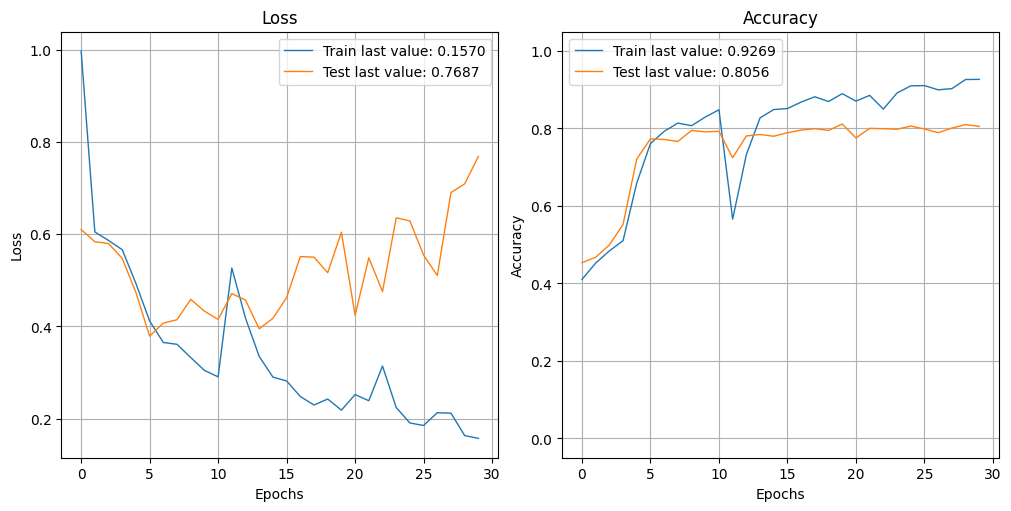

In [ ]:
from plot_keras_history import plot_history
print()
print('Below are the evaluation Results')
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")
print()
print('Below are the learning curves')
plot_history(history.history, path="std.png")
plt.show()


## Model 2: Neural bag of words using BERT

Here we will use model2 from Lab3 with BERT instead of the previous static word embeddings.

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

def get_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFDistilBertModel.from_pretrained(distil_bert, config = config)


In [ ]:
import tensorflow as tf
hdepth=16
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE=100


def create_bag_of_words_BERT():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]

  pooled_sent=GlobalAveragePooling1DMasked()(embedded_sent)
  hidden_output=Dense(hdepth,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),activation='sigmoid',kernel_initializer='glorot_uniform')(pooled_sent) # Sigmoid
  label=Dense(3,input_shape=(hdepth,),activation='softmax',kernel_initializer='glorot_uniform')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model2_BERT')


use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model2 = create_bag_of_words_BERT()
    optimizer2 = tf.keras.optimizers.Adam(learning_rate=5e-5)
    model2.compile(optimizer=optimizer2, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model2 = create_bag_of_words_BERT()
  model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
model2.summary()

Model: "Model2_BERT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_25 (TFDis  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 tilBertModel)                  ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                     

In [ ]:

history = model2.fit([x_train_int_np,x_train_masks_np],
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=([x_dev_int_np,x_dev_masks_np], y_dev),
                    verbose=1)

Epoch 1/30
22/22 [==============================] - 112s 2s/step - loss: 0.6376 - accuracy: 0.3993 - val_loss: 0.6122 - val_accuracy: 0.4354
Epoch 2/30
22/22 [==============================] - 5s 237ms/step - loss: 0.6008 - accuracy: 0.5144 - val_loss: 0.5815 - val_accuracy: 0.5946
Epoch 3/30
22/22 [==============================] - 5s 226ms/step - loss: 0.5658 - accuracy: 0.6096 - val_loss: 0.5512 - val_accuracy: 0.6479
Epoch 4/30
22/22 [==============================] - 5s 225ms/step - loss: 0.5396 - accuracy: 0.6694 - val_loss: 0.5332 - val_accuracy: 0.6922
Epoch 5/30
22/22 [==============================] - 5s 237ms/step - loss: 0.5079 - accuracy: 0.7355 - val_loss: 0.5028 - val_accuracy: 0.7508
Epoch 6/30
22/22 [==============================] - 5s 224ms/step - loss: 0.4840 - accuracy: 0.7895 - val_loss: 0.4960 - val_accuracy: 0.7628
Epoch 7/30
22/22 [==============================] - 5s 226ms/step - loss: 0.4696 - accuracy: 0.8200 - val_loss: 0.4886 - val_accuracy: 0.7935
Epoch 8

In [ ]:
results = model2.evaluate([x_test_int_np,x_test_masks_np], y_test)
print(results)

42/42 [==============================] - 2s 23ms/step - loss: 0.4474 - accuracy: 0.8241
[0.44738686084747314, 0.8241018056869507]



Below are the evaluation Results
Test Loss: 0.44738686084747314, Test Accuracy: 0.8241018056869507

Below are the learning curves


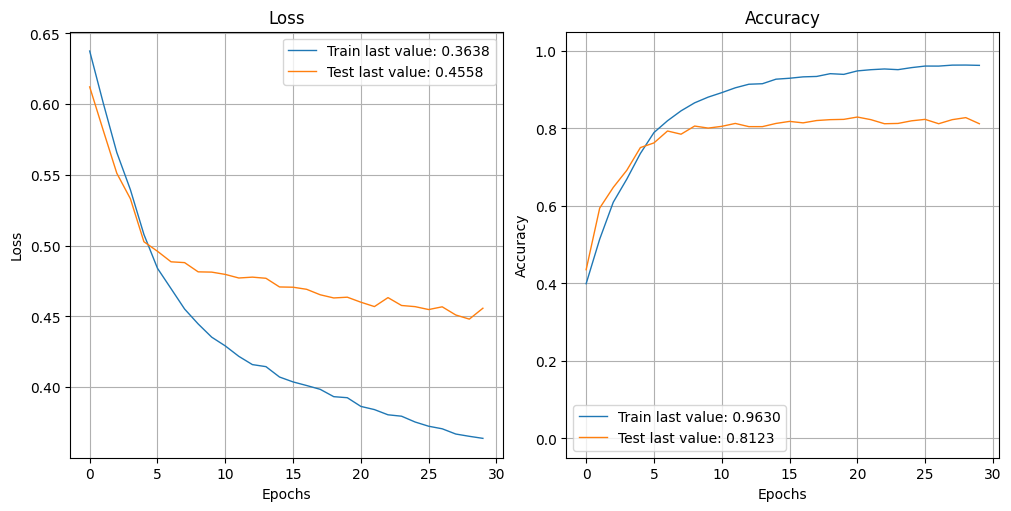

In [ ]:
print()
print('Below are the evaluation Results')
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")
print()
print('Below are the learning curves')
plot_history(history.history, path="std.png")
plt.show()

## Model 3: CNN or LSTM with BERT

Please follow the architecture for model2 to construct a CNN or an LSTM model on the top of BERT.

In [ ]:
# your code goes here
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig, TFBertModel

from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Model

def get_BERT_layer():
    distil_bert = 'distilbert-base-uncased'
    config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
    config.output_hidden_states = False
    return TFDistilBertModel.from_pretrained(distil_bert, config=config)

def get_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFDistilBertModel.from_pretrained(distil_bert, config = config)

In [ ]:
# your code goes here
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, GlobalMaxPooling1D

hdepth=16
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE=100

#ONLY TRIED - CNN ON BERT


def create_CNN_BERT():

    input_ids_in = Input(shape=(128,), name='input_token', dtype='int32')
    input_masks_in = Input(shape=(128,), name='masked_token', dtype='int32')
    bert_layer = TFBertModel.from_pretrained('bert-base-uncased')
    bert_layer.trainable = False
    bert_output = bert_layer(input_ids_in, attention_mask=input_masks_in)

    cnn_layer = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(bert_output[0])
    cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
    cnn_layer = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(cnn_layer)
    cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
    cnn_layer = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(cnn_layer)
    cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
    cnn_layer = Flatten()(cnn_layer)
    cnn_layer = Dense(units=64, activation='relu')(cnn_layer)
    cnn_layer = Dropout(rate=0.2)(cnn_layer)
    output_layer = Dense(units=3, activation='softmax')(cnn_layer)

    model = Model(inputs=[input_ids_in, input_masks_in], outputs=output_layer, name='Model2_CNN_BERT')
    return model

def create_bag_of_words_CNN():
    input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer = tf.keras.layers.Embedding(vocab_size, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH)(input_layer)

    # Convolutional layers
    conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(embedding_layer)
    pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1)
    conv2 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(pool1)
    pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv2)
    conv3 = tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(pool2)
    pool3 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv3)

    # Flatten and output layers
    flatten = tf.keras.layers.Flatten()(pool3)
    hidden_output = Dense(hdepth, activation='sigmoid', kernel_initializer='glorot_uniform')(flatten) # Sigmoid
    label = Dense(3, activation='softmax', kernel_initializer='glorot_uniform')(hidden_output)

    return tf.keras.models.Model(inputs=input_layer, outputs=label, name='Model2_CNN')



use_tpu = True
if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model3 = create_bag_of_words_CNN()
        optimizer3 = tf.keras.optimizers.Adam(lr=5e-5)
        model3.compile(optimizer=optimizer3, loss='binary_crossentropy', metrics=['accuracy'])
else:
    model3 = create_bag_of_words_CNN()
    model3.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])



Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model3.summary()

Model: "Model2_CNN_BERT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_token[0][0]',            
                                thPoolingAndCrossAt               'masked_token[0][0]']           
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                 

In [ ]:
history = model3.fit([x_train_int_np,x_train_masks_np],
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=([x_dev_int_np,x_dev_masks_np], y_dev),
                    verbose=1)


Epoch 1/30
22/22 [==============================] - 70s 2s/step - loss: 0.6025 - accuracy: 0.4521 - val_loss: 0.5606 - val_accuracy: 0.5045
Epoch 2/30
22/22 [==============================] - 4s 194ms/step - loss: 0.5562 - accuracy: 0.5235 - val_loss: 0.5251 - val_accuracy: 0.5661
Epoch 3/30
22/22 [==============================] - 4s 178ms/step - loss: 0.5211 - accuracy: 0.5776 - val_loss: 0.4981 - val_accuracy: 0.5983
Epoch 4/30
22/22 [==============================] - 4s 179ms/step - loss: 0.4949 - accuracy: 0.6092 - val_loss: 0.4844 - val_accuracy: 0.6194
Epoch 5/30
22/22 [==============================] - 4s 181ms/step - loss: 0.4800 - accuracy: 0.6271 - val_loss: 0.4785 - val_accuracy: 0.6329
Epoch 6/30
22/22 [==============================] - 4s 175ms/step - loss: 0.4790 - accuracy: 0.6312 - val_loss: 0.4671 - val_accuracy: 0.6374
Epoch 7/30
22/22 [==============================] - 4s 185ms/step - loss: 0.4628 - accuracy: 0.6447 - val_loss: 0.4614 - val_accuracy: 0.6434
Epoch 8/

42/42 [==============================] - 13s 157ms/step - loss: 0.4643 - accuracy: 0.6961

Below are the evaluation Results
Test Loss: 0.4642699062824249, Test Accuracy: 0.696107804775238

Below are the learning curves


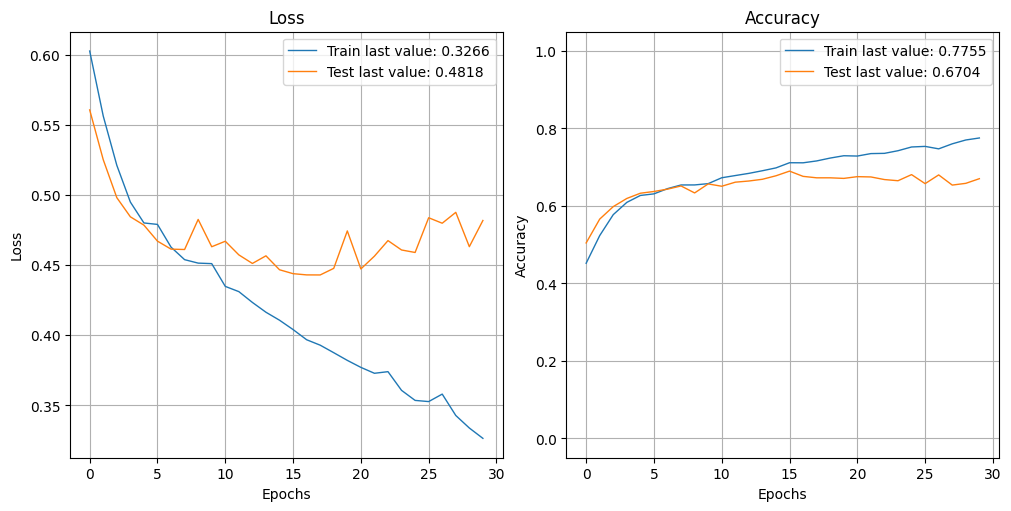

In [ ]:
results = model3.evaluate([x_test_int_np,x_test_masks_np], y_test)
print()
print('Below are the evaluation Results')
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")
print()
print('Below are the learning curves')
plot_history(history.history, path="std.png")
plt.show()

To try LSTM architecture on the model, refer to https://aclanthology.org/W19-6120.pdf